In [1]:
import matplotlib.pyplot as plt
import numpy as np
from order_fulfillment_environment import OrderFulfillment
from fulfillment_policy import FulfillmentPolicy
from tqdm import tqdm

# Small Network $J=10, K=5, n=20, T=10^5$

Moreover:
- $n = 20$ (number of items)
- $n_{max} \in \{2,5,10\}$
- $n_0 = 5$
- $p_{stock} = 0.75$

### $n_{max} = 2$

In [2]:
# fulfillment_instance = OrderFulfillment(num_items=20, n_max=5, n_0=5,
#                                         p_stock=1, T=100, CSL=0.5,
#                                         facilities_data="Data/fulfillment_centers_warmup_test.csv", 
#                                         cities_data="Data/cities_warmup_test.csv",
#                                         prob_seed_value=11,
#                                         order_seed_value=11,
#                                         inv_seed_value=11)

# print(fulfillment_instance.fixed_costs)
# print(fulfillment_instance.unit_costs)

In [3]:
# fulfillment_instance.order_types

In [4]:
# fulfillment_instance.demand_distribution_by_type_by_location

In [5]:
# sum(fulfillment_instance.demand_distribution_by_type_by_location[0:2][0][0])

In [6]:
# sum(fulfillment_instance.demand_distribution_by_type_by_location[0:2][0][0]) + sum([sum(fulfillment_instance.demand_distribution_by_type_by_location[0:2][1][i]) for i in range(4)])

In [7]:
# fulfillment_instance.all_methods_location[-25]['methods']

In [8]:
# fulfillment_instance.all_costs[-25]

In [9]:

def evaluate_policies(conservative_prob=0.01, T=10**2, num_instances=50, num_order_sequences=50, plot=False, modified=True):

    times_our_policy_is_better = 0
    times_our_policy_equal = 0
    times_our_policy_worse = 0
    
    instances = np.arange(1, num_instances + 1)
    
    expected_cost_our_policy = []
    expected_cost_aa = []
    cost_difference = []
    
    # Accumulators for total cost
    total_cost_our_policy = 0
    total_cost_aa = 0

    times_our_policy_better = []
    times_aa_better = []
    times_same_cost = []
    
    for instance in instances:
        print('Instance', instance)
        
        fulfillment_instance = OrderFulfillment(num_items=20, n_max=5, n_0=5,
                                                p_stock=1, T=T, CSL=0.5,
                                                facilities_data="Data/fulfillment_centers_warmup_test.csv", cities_data="Data/cities_warmup_test.csv", prob_seed_value=instance, order_seed_value=instance, inv_seed_value=instance)
        # Create an instance of FulfillmentPolicy (same as fulfillment_instance in this case)
        fulfillment_policy = FulfillmentPolicy(num_items=20, n_max=5, n_0=5,
                                                p_stock=1, T=T, CSL=0.5,
                                                facilities_data="Data/fulfillment_centers_warmup_test.csv", cities_data="Data/cities_warmup_test.csv", prob_seed_value=instance, order_seed_value=instance, inv_seed_value=instance)
        # Generate magician problems (dictionary where the keys are (i,k))
        magician_problems = fulfillment_policy.generate_magician_problems(conservative_prob=conservative_prob)
        
        
        # FOR EACH INSTANCE, GENERATE DIFFERENT ORDER SEQUENCES (i.e. order arrivals through time)
        order_sequences = np.arange(1, num_order_sequences + 1) # seed_value for each order sequence

        count_fulfillment_policy = 0
        count_always_accept_policy = 0
        tie = 0

        expected_policy_cost = 0
        expected_policy_cost_aa = 0

        # for order_sequence in tqdm(order_sequences):
        for order_sequence in tqdm(order_sequences):
            
            # Initialize inventory consumption for our fulfillment policy
            if modified:
                inventory_consumption = fulfillment_policy.initialize_inventory_consumption()
                sampled_orders_index, sampled_orders, sampled_methods, accepts_decisions, fulfillment_costs = fulfillment_policy.modified_fulfillment_policy(inventory_consumption, magician_problems, seed_value=order_sequence)
                fulfillment_policy.check_consistency(inventory_consumption)
                total_fulfillment_cost = sum(fulfillment_costs)
                print(sampled_orders)
            else:
                inventory_consumption = fulfillment_policy.initialize_inventory_consumption()
                sampled_orders_index, sampled_orders, sampled_methods, accepts_decisions, fulfillment_costs = fulfillment_policy.fulfillment_policy(inventory_consumption, magician_problems, seed_value=order_sequence)
                fulfillment_policy.check_consistency(inventory_consumption)
                total_fulfillment_cost = sum(fulfillment_costs)
                print(sampled_orders)
            
            # Initialize inventory consumption for always_accept_policy
            inventory_consumption_aa = fulfillment_policy.initialize_inventory_consumption()
            sampled_orders_index_aa, sampled_orders_aa, sampled_methods_aa, accepts_decisions_aa, fulfillment_costs_aa = fulfillment_policy.always_accept_policy(inventory_consumption_aa, seed_value=order_sequence)
            fulfillment_policy.check_consistency(inventory_consumption)
            total_always_accept_cost = sum(fulfillment_costs_aa)
            print(sampled_orders_aa)

            expected_policy_cost += total_fulfillment_cost
            expected_policy_cost_aa += total_always_accept_cost

            # Check which policy has lower costs and update counters accordingly
            if total_fulfillment_cost < total_always_accept_cost:
                count_fulfillment_policy += 1
            elif total_always_accept_cost < total_fulfillment_cost:
                count_always_accept_policy += 1
            elif total_fulfillment_cost == total_always_accept_cost:
                tie += 1

        expected_policy_cost = round(expected_policy_cost/num_order_sequences,2) # expected cost over the number of order sequences
        expected_policy_cost_aa = round(expected_policy_cost_aa/num_order_sequences,2) # expected cost over the number of order sequences

        total_cost_our_policy += expected_policy_cost
        total_cost_aa += expected_policy_cost_aa

        if expected_policy_cost < expected_policy_cost_aa:
            times_our_policy_is_better += 1
        elif expected_policy_cost > expected_policy_cost_aa:
            times_our_policy_worse += 1
        elif expected_policy_cost == expected_policy_cost_aa:
            times_our_policy_equal += 1
            
        expected_cost_our_policy.append(expected_policy_cost)
        expected_cost_aa.append(expected_policy_cost_aa)
        cost_difference.append(expected_policy_cost-expected_policy_cost_aa)
        
        times_our_policy_better.append(count_fulfillment_policy)
        times_aa_better.append(count_always_accept_policy)
        times_same_cost.append(tie)
    
    # Calculate average expected costs across instances
    average_cost_our_policy = total_cost_our_policy / num_instances
    average_cost_aa = total_cost_aa / num_instances
            
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(instances, cost_difference, label='Difference our_policy-aa_policy', marker='o')
        plt.xlabel('Instance')
        plt.ylabel('Cost Difference')
        plt.title('Difference in Expected Total Cost vs. Instance')
        plt.legend()
        plt.grid(True)
        plt.show()

    results = {
        "avg_cost_our_policy_over_instances": average_cost_our_policy,
        "avg_cost_aa_over_instances": average_cost_aa,
        "expected_cost_our_policy_per_instance": expected_cost_our_policy,
        "expected_cost_aa_per_instance": expected_cost_aa,
        "expected_cost_difference_per_instance": cost_difference,
        "percent_better": times_our_policy_is_better / num_instances * 100,
        "percent_equal": times_our_policy_equal / num_instances * 100,
        "percent_worse": times_our_policy_worse / num_instances * 100
    }
    
    # with open(f'results_{T}.txt', 'w') as f:
    #     f.write("Expected cost of our policy: " + str(avg_cost_our_policy) + "\n")
    #     f.write("Expected cost of always_accept_policy: " + str(avg_cost_aa) + "\n")
    #     f.write("Number of times magician-based fulfillment policy is better: " + str(times_our_policy_better) + "\n")
    #     f.write("Number of times always_accept_policy is better: " + str(times_aa_better) + "\n")
    #     f.write("Policies have the same cost: " + str(times_same_cost) + "\n")
    
    return results


Instance 1


100%|██████████| 1/1 [00:00<00:00, 495.25it/s]


[((18,), 0), ((0, 7, 14, 16), 0), ((0, 14, 19), 0), ((0, 17, 19), 0), ((18,), 0), ((7, 11, 15, 17), 0), ((0, 7, 14, 16), 0), ((12, 13), 0)]
[((18,), 0), ((0, 7, 14, 16), 0), ((0, 14, 19), 0), ((0, 17, 19), 0), ((18,), 0), ((7, 11, 15, 17), 0), ((0, 7, 14, 16), 0), ((12, 13), 0)]
Instance 2


100%|██████████| 1/1 [00:00<00:00, 487.03it/s]


[((), 0), ((11, 16, 17), 1), ((8, 9), 1), ((5, 18), 0), ((), 0), ((8, 14, 16), 1), ((11, 16, 17), 1), ((5,), 1)]
[((), 0), ((11, 16, 17), 1), ((8, 9), 1), ((5, 18), 0), ((), 0), ((8, 14, 16), 1), ((11, 16, 17), 1), ((5,), 1)]
Instance 3


100%|██████████| 1/1 [00:00<00:00, 484.27it/s]


[((18,), 0), ((0, 7, 8, 10, 18), 0), ((12, 15, 17), 0), ((6, 8, 9, 13), 0), ((7,), 0), ((3, 5, 6, 10, 19), 0), ((0, 7, 8, 10, 18), 0), ((7, 17), 0)]
[((18,), 0), ((0, 7, 8, 10, 18), 0), ((12, 15, 17), 0), ((6, 8, 9, 13), 0), ((7,), 0), ((3, 5, 6, 10, 19), 0), ((0, 7, 8, 10, 18), 0), ((7, 17), 0)]
Instance 4


100%|██████████| 1/1 [00:00<00:00, 502.01it/s]


[((7,), 1), ((6, 9, 13, 18), 1), ((5, 6, 8), 0), ((2, 10, 12, 16), 1), ((), 1), ((1, 2, 8, 14, 18), 0), ((6, 9, 13, 18), 1), ((0, 6, 8), 0)]
[((7,), 1), ((6, 9, 13, 18), 1), ((5, 6, 8), 0), ((2, 10, 12, 16), 1), ((), 1), ((1, 2, 8, 14, 18), 0), ((6, 9, 13, 18), 1), ((0, 6, 8), 0)]
Instance 5


100%|██████████| 1/1 [00:00<00:00, 496.07it/s]


[((), 1), ((0, 5, 11, 13), 0), ((0, 6, 13), 1), ((6, 10, 17, 18), 0), ((), 0), ((2, 4, 8, 9, 10), 0), ((0, 5, 11, 13), 0), ((7, 15), 1)]
[((), 1), ((0, 5, 11, 13), 0), ((0, 6, 13), 1), ((6, 10, 17, 18), 0), ((), 0), ((2, 4, 8, 9, 10), 0), ((0, 5, 11, 13), 0), ((7, 15), 1)]


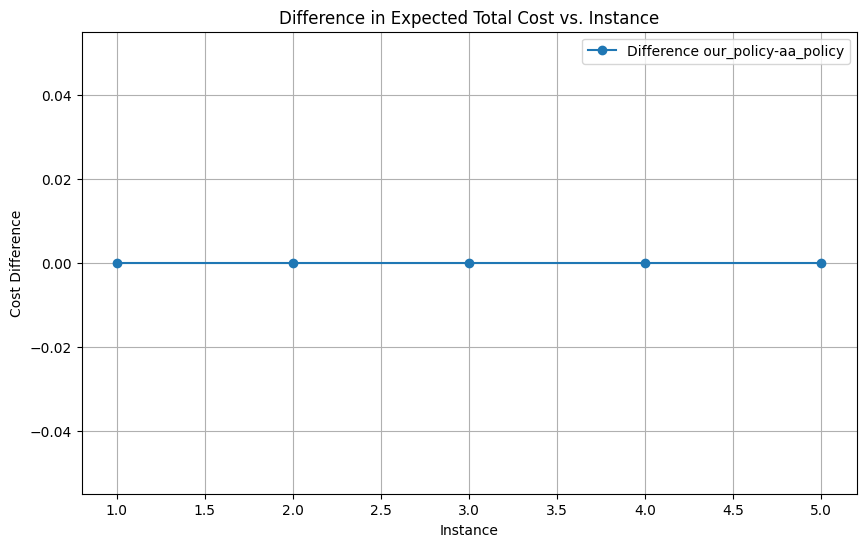

{'avg_cost_our_policy_over_instances': 214.964,
 'avg_cost_aa_over_instances': 214.964,
 'expected_cost_our_policy_per_instance': [223.41,
  161.99,
  307.77,
  147.65,
  234.0],
 'expected_cost_aa_per_instance': [223.41, 161.99, 307.77, 147.65, 234.0],
 'expected_cost_difference_per_instance': [0.0, 0.0, 0.0, 0.0, 0.0],
 'percent_better': 0.0,
 'percent_equal': 100.0,
 'percent_worse': 0.0}

In [12]:
evaluate_policies(conservative_prob=0.01, T=8, num_instances=5, num_order_sequences=1, plot=True, modified=True)

Instance 1


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Instance 2
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Instance 3


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Instance 4


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Instance 5


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Instance 6


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Instance 7


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Instance 8


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Instance 9


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Instance 10
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Instance 11
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


Instance 12


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


Instance 13


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


Instance 14


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


Instance 15


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Instance 16
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Instance 17
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Instance 18


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]


Instance 19
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Instance 20


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Instance 21
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Instance 22


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Instance 23
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


Instance 24
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Instance 25
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Instance 26
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Instance 27


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Instance 28


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Instance 29
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


Instance 30
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Instance 31
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Instance 32


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


Instance 33


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Instance 34


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Instance 35
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Instance 36


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


Instance 37
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Instance 38
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


Instance 39
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Instance 40


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Instance 41
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


Instance 42
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Instance 43


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Instance 44


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]


Instance 45
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Instance 46
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Instance 47


100%|██████████| 50/50 [00:26<00:00,  1.85it/s]


Instance 48
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Instance 49
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Instance 50
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones
expected number of broken wands larger than the available ones


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


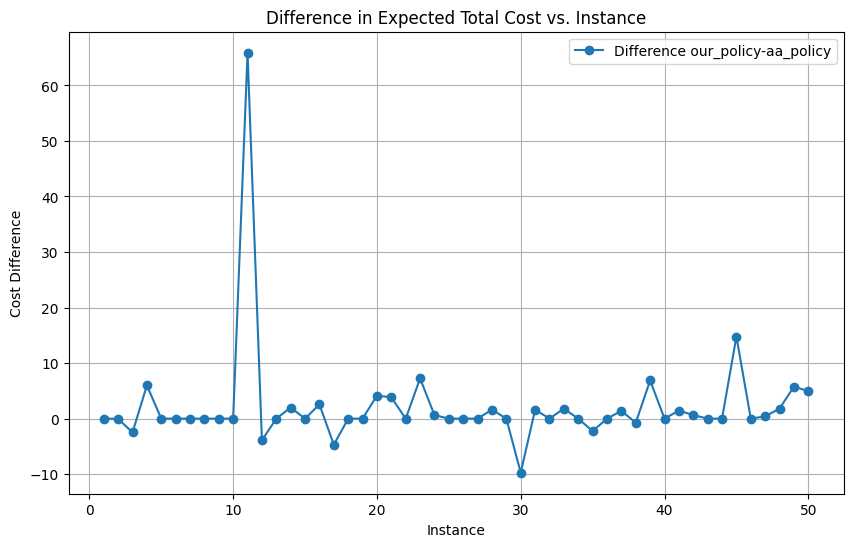

{'avg_cost_our_policy_over_instances': 39922.34100000001,
 'avg_cost_aa_over_instances': 39920.1098,
 'expected_cost_our_policy_per_instance': [35415.22,
  38169.54,
  36038.4,
  35817.25,
  33468.16,
  30784.5,
  31477.64,
  32855.97,
  28514.64,
  43676.76,
  63806.11,
  33053.76,
  36712.68,
  37030.76,
  24515.55,
  50134.01,
  43685.93,
  35070.71,
  41601.1,
  32290.4,
  62161.53,
  25510.14,
  42035.39,
  36352.87,
  42397.17,
  38285.43,
  31512.42,
  37996.02,
  45477.27,
  47346.8,
  65761.74,
  37027.01,
  33888.21,
  31066.52,
  47324.58,
  37369.49,
  44827.06,
  40435.01,
  42610.8,
  30276.91,
  47384.4,
  47548.83,
  38971.45,
  33113.0,
  47506.25,
  42138.05,
  34635.7,
  50970.44,
  45919.76,
  44147.71],
 'expected_cost_aa_per_instance': [35415.22,
  38169.57,
  36040.89,
  35811.27,
  33468.16,
  30784.5,
  31477.64,
  32855.97,
  28514.64,
  43676.76,
  63740.22,
  33057.65,
  36712.68,
  37028.76,
  24515.55,
  50131.45,
  43690.63,
  35070.71,
  41601.1,
  32286

In [11]:
evaluate_policies(conservative_prob=0.0001, T=3000, num_instances=50, num_order_sequences=50, plot=True, modified=False)

In [ ]:
def find_best_conservative_prob(start=0.01, stop=1.0, step=0.01, **kwargs):
    best_prob = start
    results = evaluate_policies(conservative_prob=start, **kwargs)
    best_times_our_policy_better_or_equal = results['percent_better'] + results['percent_equal']
    best_average_cost_diff = results["avg_cost_our_policy_over_instances"] - results["avg_cost_aa_over_instances"]

    for prob in np.arange(start + step, stop + step, step):
        results = evaluate_policies(conservative_prob=prob, **kwargs)
        current_times_our_policy_better_or_equal = results['percent_better'] + results['percent_equal']
        current_average_cost_diff = results["avg_cost_our_policy_over_instances"] - results["avg_cost_aa_over_instances"]
        
        # Update the best_prob if the current probability results in our policy being at least as often better or equal than before
        # and if the average cost of our policy is greater than the average cost of the always_accept_policy
        if current_times_our_policy_better_or_equal >= best_times_our_policy_better_or_equal and current_average_cost_diff > best_average_cost_diff and prob > best_prob:
            best_prob = prob
            best_times_our_policy_better_or_equal = current_times_our_policy_better_or_equal
            best_average_cost_diff = current_average_cost_diff
            
    return best_prob


best_prob = find_best_conservative_prob()
print(f"The 'best' conservative_prob based on the new criteria is: {best_prob}")


In [ ]:
evaluate_policies(conservative_prob=best_prob, T=10**1, num_instances=50, num_order_sequences=50, plot=True, modified=True)